### Set Parameters


In [1]:
EPISODES = 100
env_name = "mlagents/envs/3DBall_128"  # Name of the Unity environment binary to launch
train_mode = True  # Whether to run the environment in training or inference mode

### Import Dependencies
#### DQN

In [2]:
# -*- coding: utf-8 -*-
# DQN part
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Model

Using TensorFlow backend.


#### Unity

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import pylab as pl
from IPython import display
from mlagents.envs import UnityEnvironment

%matplotlib inline

print("Python version:")
print(sys.version)

# check Python version
if (sys.version_info[0] < 3):
    raise Exception("ERROR: ML-Agents Toolkit (v0.3 onwards) requires Python 3")

Python version:
3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


### Define DQN Agent

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape = self.state_size)
        model_vgg16_conv.trainable = False
        
        #Create your own input format (here 3x200x200)
        model = Sequential()
        model.add(model_vgg16_conv)
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten(name='flatten'))
        model.add(Dense(32, activation='relu', name='fc1'))
        model.add(Dense(32, activation='relu', name='fc2'))
        model.add(Dense(self.action_size, activation='linear', name='predictions'))
        
        #Create your own model 
        #model = Model(input=input, output=x)
        
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(np.expand_dims(state,axis = 0))
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(np.expand_dims(next_state,axis = 0))[0]))
            target_f = self.model.predict(np.expand_dims(state,axis = 0))
            target_f[0][action] = target
            self.model.fit(np.expand_dims(state,axis = 0), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


### Start Environment

In [5]:
env = UnityEnvironment(file_name=env_name)

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:mlagents.envs:
'Ball3DAcademy' started successfully!
Unity Academy name: Ball3DAcademy
        Number of Brains: 1
        Number of External Brains : 1
        Reset Parameters :
		
Unity brain name: Ball3DBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: , 


### Run DQN

In [6]:
env_info = env.reset(train_mode=train_mode)[default_brain]
observation = env_info.visual_observations[0][0,:,:,:]
state_size = observation.shape

action_size = 25
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")
done = False
batch_size = 32
total_perform = np.zeros([EPISODES,1])

for e in range(EPISODES):
    env_info = env.reset(train_mode=train_mode)[default_brain]
    observation = env_info.visual_observations[0][0,:,:,:]
    episode_rewards = 0
    for time in range(500):
        # env.render()   
        action = agent.act(observation)
        env_info = env.step([(np.mod(action,5)-2)/4,(np.ceil((action+1)/5)-3)/4])[default_brain]
        reward = env_info.rewards[0]
        #reward = reward if not done else -10
        episode_rewards += reward
        done = env_info.local_done[0]
        next_observation = env_info.visual_observations[0][0,:,:,:]
        agent.remember(observation, action, reward, next_observation, done)
        observation = next_observation.copy()
        if done:
            print("episode: {}/{}, score: {}, e: {:.6}"
                  .format(e, EPISODES, time, agent.epsilon))
            total_perform[e] = time
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    # if e % 10 == 0:
    #     agent.save("./save/cartpole-dqn.h5")

episode: 0/100, score: 37, e: 0.975249
episode: 1/100, score: 20, e: 0.88222
episode: 2/100, score: 19, e: 0.802076
episode: 3/100, score: 20, e: 0.725566
episode: 4/100, score: 51, e: 0.561894
episode: 5/100, score: 22, e: 0.503225
episode: 6/100, score: 23, e: 0.448428
episode: 7/100, score: 17, e: 0.411799
episode: 8/100, score: 14, e: 0.383891
episode: 9/100, score: 19, e: 0.349017
episode: 10/100, score: 25, e: 0.30791
episode: 11/100, score: 24, e: 0.27301
episode: 12/100, score: 19, e: 0.248208
episode: 13/100, score: 23, e: 0.221181
episode: 14/100, score: 22, e: 0.198087
episode: 15/100, score: 23, e: 0.176517
episode: 16/100, score: 18, e: 0.161288
episode: 17/100, score: 20, e: 0.145903
episode: 18/100, score: 19, e: 0.132648
episode: 19/100, score: 19, e: 0.120598
episode: 20/100, score: 23, e: 0.107466
episode: 21/100, score: 27, e: 0.0938629
episode: 22/100, score: 33, e: 0.0795529
episode: 23/100, score: 19, e: 0.072326
episode: 24/100, score: 21, e: 0.0650997
episode: 2

<function matplotlib.pyplot.close(fig=None)>

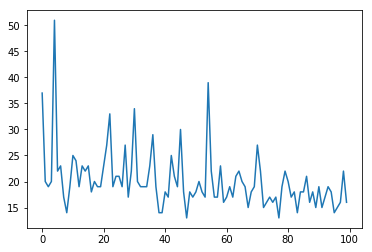

In [8]:
plt.figure
plt.plot(total_perform)
plt.close

In [9]:
episode_rewards

0.6000000238418579

In [10]:
x = np.expand_dims(observation, axis=0)
x.shape

(1, 128, 128, 3)